[Colab](https://colab.research.google.com/github/dominik-strutz/Endurance_CCS_design_study/blob/main/endurance_boulby_noiselevel.ipynb)

In [1]:

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False


if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! pip install --quiet zuko
        ! pip install --quiet cartopy
        ! pip install --quiet git+https://github.com/dominik-strutz/GeoBED.git@48679d7ba3b361bc533af08a2584ed047e8f74d6
        ! pip install --quiet ax-platform
        ! pip install --quiet pykonal
        ! pip install --quiet netCDF4

        # ! pip install --quiet obspy
        # clean up working directory
        ! rm -rf *

        ! git clone --quiet https://github.com/dominik-strutz/Endurance_CCS_design_study tmp
        ! mv tmp/* .
        ! rm -rf tmp
        
        ! mkdir data/eikonal_lookup
        ! gdown -O data/eikonal_lookup/eikonal_lookup_layered_10_rdepth_10_sdepth_500_distance.nc https://drive.google.com/uc?id=1o5V3t5qu4-XiZBPd34SWus-yUI00tx5_    
    
        dependencies_installed = True

In [2]:
import os
import torch.distributions as dist
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

from tqdm.notebook import tqdm

import cartopy.crs as ccrs
import xarray as xr

In [3]:
from helpers import *

In [4]:
from geobed.core import BED_base_explicit

data_likelihood = Data_Likelihood(Forward_Class, 1.0, 0.02)

Test_BED = BED_base_explicit(
    data_likelihood_dist=data_likelihood,
    m_prior_dist=prior_dist,
    )

In [5]:
design_seis_only = seismic_inventory.to_numpy()
design_seis_only[:, :2] = seismic_stations_xy[:, :2]
design_seis_only = torch.from_numpy(design_seis_only).float()
# design_seis_only[:, 2] = -1 * design_seis_only[:, 2]

In [6]:
avg_surface_seis_noise = design_seis_only[:, -1].mean()
print(f'Average surface seismic noise: {avg_surface_seis_noise:.2f} s')

mine_latlon = boulby_mine_latlon[None, :]
mine_xy = latlong2xy(mine_latlon[:, 0], mine_latlon[:, 1], topo_data_latlon)
mine_depth = boulby_mine_latlon[2]

mine_relative_noise_level = np.logspace(1, -3, 21)

design_list_mine_noise = []

for nl_i in mine_relative_noise_level:

    design_i = design_seis_only.clone()
    boulby_data = torch.tensor([mine_xy[0, 0], mine_xy[0, 1], mine_depth, avg_surface_seis_noise*nl_i])
    
    design_i = torch.cat((design_i, boulby_data[None, :]), dim=0)    
    
    design_list_mine_noise.append(design_i)
    
design_list_mine_noise = torch.stack(design_list_mine_noise).float()

Average surface seismic noise: 0.90 s


In [7]:
T = int(1e4)

eig_nmc, out_nmc = Test_BED.calculate_EIG(
    design=design_list_mine_noise,
    eig_method='NMC',
    eig_method_kwargs={
        'N': T,
        # 'M': M,
        'reuse_M':True,
        'memory_efficient':True},
    num_workers=5,
    random_seed=1,
    filename='data/mine_noise_level_comparison/endurance_mine_noise_level_nmc',
)

In [8]:
T = int(1e4)

eig_dn, out_dn = Test_BED.calculate_EIG(
    design=design_list_mine_noise,
    eig_method='DN',
    eig_method_kwargs={'N': T, },
    num_workers=5,
    # parallel_library='joblib',
    random_seed=1,
    filename='data/mine_noise_level_comparison/endurance_mine_noise_level_dn',
)

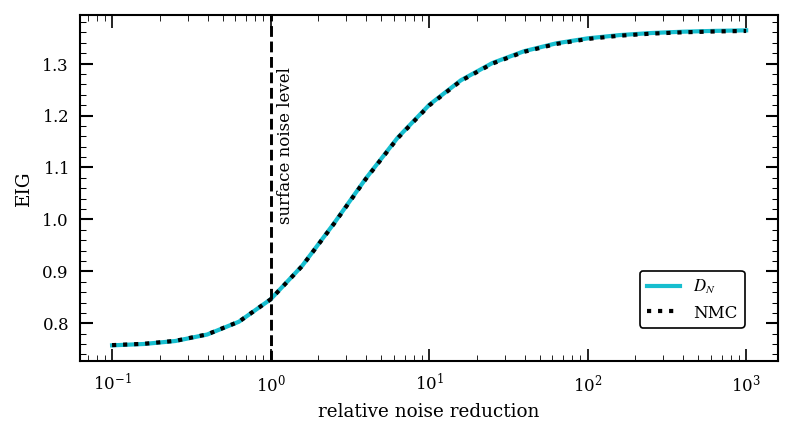

In [9]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)

ax.plot(1/mine_relative_noise_level, eig_dn, label=r"$D_N$", color="tab:cyan", linestyle="-", linewidth=2)
ax.plot(1/mine_relative_noise_level, eig_nmc, label="NMC", color="black", linestyle=":", linewidth=2)

ax.axvline(1, color="black", linestyle="--")
ax.text(1.1, ax.get_ylim()[1]-0.15*(ax.get_ylim()[1]-ax.get_ylim()[0]), "surface noise level", rotation=90, verticalalignment="top", fontsize=8)

ax.set_xlabel("relative noise reduction")
ax.set_ylabel("EIG")

# ax.set_xlim(0.1, 1000)
# ax.set_ylim(1.5, 2.1)

ax.set_xscale("log")

ax.legend(loc="lower right", fontsize=8)

plt.show()

In [10]:
true_event = torch.tensor([335.0, 245.0, -1.02]) *1e3
true_depth = true_event[2]

N_grid_posterior = 50

local_x_min, local_x_max = 315_000, 350_000
local_y_min, local_y_max = 235_000, 260_000
local_z_min, local_z_max = -3_000, 0

x_local = torch.linspace(local_x_min, local_x_max, N_grid_posterior)
y_local = torch.linspace(local_y_min, local_y_max, N_grid_posterior)
z_local = torch.linspace(local_z_min, local_z_max, N_grid_posterior)

100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


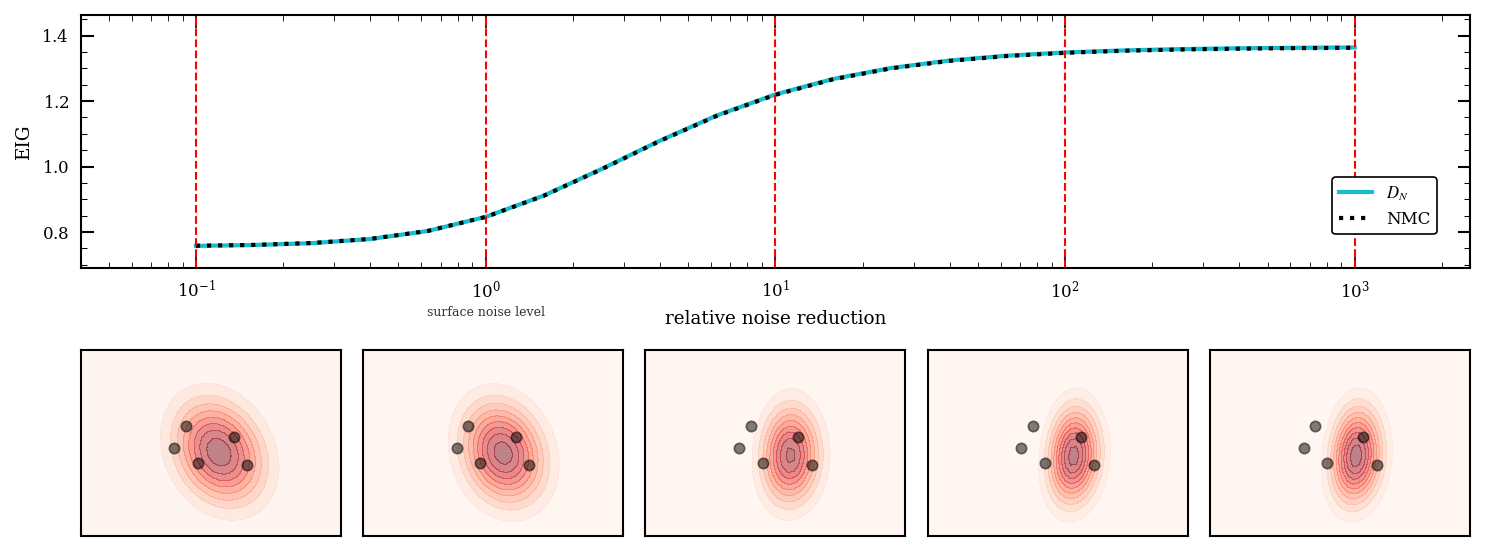

In [11]:
posterior_indicies = ['0', '5', '10', '15', '20']

fig, ax_dict = plt.subplot_mosaic([['a', 'a', 'a', 'a', 'a'],
                                   posterior_indicies      ],
                                  figsize=(10, 4),)

ax = ax_dict['a']

ax.plot(1/mine_relative_noise_level, eig_dn, label=r"$D_N$", color="tab:cyan", linestyle="-", linewidth=2)
ax.plot(1/mine_relative_noise_level, eig_nmc, label="NMC", color="black", linestyle=":", linewidth=2)

ax.set_ylim(ax.get_ylim()[0]*0.95, ax.get_ylim()[1]*1.05)

# ax.axvline(1, color="black", linestyle="--")
ax.text(
    1.0, ax.get_ylim()[0]-0.15*(ax.get_ylim()[1]-ax.get_ylim()[0]), "surface noise level", rotation=0,
    verticalalignment="top", horizontalalignment='center',
    fontsize=6, clip_on=False, alpha=0.8)

ax.set_xlabel("relative noise reduction")
ax.set_ylabel("EIG")

ax.set_xlim(0.1*0.4, 1000*2.5)

ax.set_xscale("log")

ax.legend(loc="lower right", fontsize=8, frameon=True, facecolor='white', framealpha=1)

for i in tqdm.tqdm(range(5)):
    ax = ax_dict[posterior_indicies[i]]
    
    design_i = int(posterior_indicies[i])
    relative_noise_level = mine_relative_noise_level[design_i]
    
    ax_dict['a'].axvline(1/relative_noise_level, ymin=0.0, ymax=1.0, clip_on=False,  
                         color='red', linestyle='--', linewidth=1)
        
    filename = f'data/mine_noise_level_comparison/endurance_mine_noise_level_posterior_comparison_{design_i}'
    
    if os.path.exists(filename):
        out = torch.load(filename)
    else:           
        tt_obs = Forward_Class(true_event[None, :], design_list_mine_noise[design_i]).squeeze()

        out = gridsearch_posterior(tt_obs, x_local, y_local, z_local, design_list_mine_noise[design_i],
                                   prior_dist, data_likelihood)
        torch.save(out, filename)

    p_posterior, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z = out
    
    plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local, 
    slice_axis='z', slice_value=true_depth,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},
    # hornsea = hornsea_4_xy,
    # endurance = endurance_area_xy,
    wells=wells_coords_xy,
    # true_event=true_event,
    )
    
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    # ax.set_xticks(np.linspace(local_x_min, local_x_max, 3))
    # ax.set_xticklabels([f'{v/1000:.0f}' for v in ax.get_xticks()])
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    # if i == 0:
    #     ax.set_yticks(np.linspace(local_y_min, local_y_max, 3))
    #     ax.set_yticklabels([f'{v/1000:.0f}' for v in ax.get_yticks()])
    # else:
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    ax.get_legend().remove()

    # ax.set_title(f'{1/relative_noise_level:.1f}')
    
    try:
        ax_dict['0'].sharey(ax)
    except:
        pass
    
    
plt.tight_layout()
plt.show()